In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt5
%matplotlib inline

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
from plot_helpers import *
import numpy as np
import os
import math
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

# plt.style.use('ggplot')
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]

# Figure sizes
default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

EXP_list = [exp_folder.split('experiment_')[-1][:-1] for exp_folder in sorted(glob.glob('%s/*/' % datadir))]

EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Experiment:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    #rows=10,
    description='Experiment:',
    disabled=False,
)


figfolder = 'plots'
display(EXP_drop)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dropdown(description='Experiment:', index=5, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '130_st…

## Time elapsed between blocks

SelectMultiple(description='Experiment:', index=(1,), options=('100_epsilon_1', '110_epsilon', '130_staking', …

Experiment datasets: 110_epsilon
New plot directory is created!


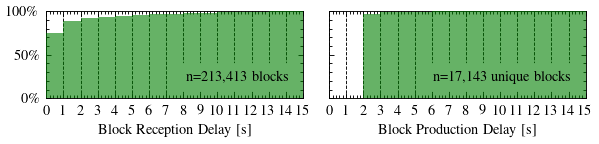

In [23]:
display(EXP_multiple)
EXP = EXP_multiple.value
# display(EXP_drop)
# EXP = EXP_drop.value
print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'block')
# df = df.get_param(df,'generic_params','block_period')
XMAX = 15

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create figure
fig, ax = plt.subplots(1,2, sharey=True, figsize=flhh)

# Create plot
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder= 3)
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder=3)
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[1].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
fig.tight_layout()
# plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

Dropdown(description='Experiment:', index=34, options=('backup_test116_patchy_single_', 'test101', 'test102', …

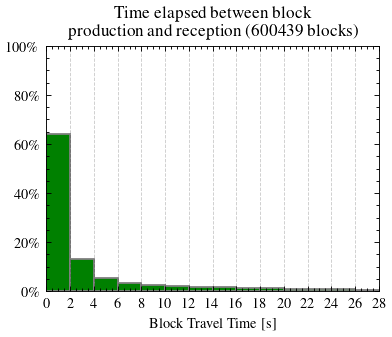

In [3]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')
df = df.get_param(df,'generic_params','block_period')

# Process the data  
bins = range(0, 30, df['block_period'].min())
# XX = df.groupby('HASH')['TELAPSED'].agg('max')
XX = df['TELAPSED']

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between consecutive blocks

Dropdown(description='Experiment:', index=17, options=('backup_test116_patchy_single_', 'test101', 'test102', …

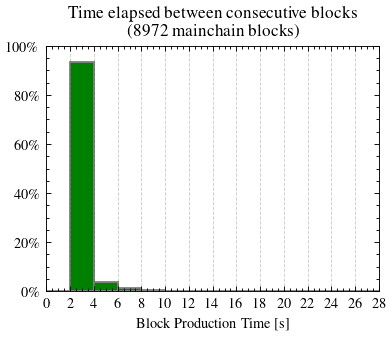

In [6]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')

# Process the dataframe  
df = df.get_param(df,'generic_params','block_period')
bins = range(0, 30, df['block_period'].min())

df = df.drop_duplicates('HASH')
df = trim_chain(df, 8).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Local memory occupied by chaindata

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

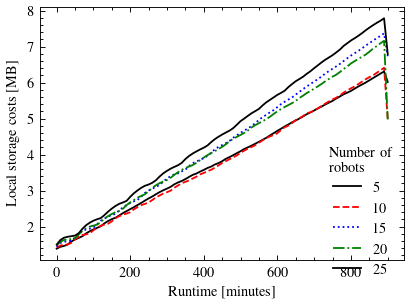

In [3]:
# display(EXP_multiple)
# EXP = EXP_multiple.value
display(EXP_drop)
EXP = EXP_drop.value
# print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df2(EXP, 'extra', exclude_patterns = ['greedy'])
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

df['TEMP'] = df['TIME']/10
df['TIME_S'] = df['TEMP'].round().astype(int) * 10

# df = df.query('REP == "001"')
# display(df)
# Process the dataframe  
# df = df.groupby(['Robots']).apply(lambda x: LinearRegression(x, 'TIME', 'MB'))

# display(df[['Robots','MB']])
# Create plot


ax = plt.axes()
# display(df)
# df = df[['Robots','TIME_M','MB']]
# display(df.groupby(['Robots', 'TIME_M'], as_index=False).mean().set_index('TIME_M')['MB'])

df.groupby(['Robots', 'TIME_S'], as_index=False).mean().set_index('TIME_S')[['Robots','MB']].groupby('Robots')['MB'].plot(ax=ax)

# df.groupby('Robots').boxplot(column='MB', by='TIME_MR', figsize=double)
# sns.boxplot(x=df['TIME_MR'], y=df['MB'], hue=df['Robots'], showfliers = False)

# display(df)
# s = df.pivot('TIME_M', 'ID', 'MB').mean(axis=1).resample('0.15S').mean()

# display(df)
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP')['MB'].transform(lambda x: x.rolling(10, 1).mean())
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP').rolling(10)['MB'].mean().reset_index(drop=True)
# display(df)
# s.plot(ax = ax, figsize = double)
# display(df)
# df.set_index(['TIME']).groupby(['EXP', 'REP', 'ID'])['MB'].plot(ax = ax, color='gray', label='_nolegend_', linewidth=0.2, alpha = 0.1, zorder=0)

# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Local storage costs [MB]')
ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

       ID     TIME       MB  REP              EXP             CFG  \
11576   1    0.543  1.43059  014  test120_scaling  10_blockchain2   
11577   1   10.606  1.46004  014  test120_scaling  10_blockchain2   
11578   1   20.649  1.46004  014  test120_scaling  10_blockchain2   
11579   1   30.694  1.46004  014  test120_scaling  10_blockchain2   
11580   1   40.791  1.53333  014  test120_scaling  10_blockchain2   
...    ..      ...      ...  ...              ...             ...   
51209   9  859.546  4.87961  010  test120_scaling  20_blockchain2   
51210   9  869.683  4.93754  010  test120_scaling  20_blockchain2   
51211   9  879.926  5.01139  010  test120_scaling  20_blockchain2   
51212   9  890.042  5.11349  010  test120_scaling  20_blockchain2   
51213   9  900.225  5.20095  010  test120_scaling  20_blockchain2   

        CONTROLLER  Robots     TIME_M     COEFS      LREG  
11576  blockchain2      10   0.009050  0.285587  0.002585  
11577  blockchain2      10   0.176767  0.285587  0.

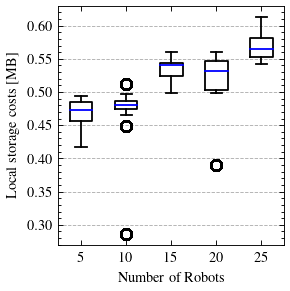

In [4]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'extra')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df['TIME_M'] = df['TIME']/60
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'MB'
yl = 'Local storage costs [MB]'
fs = hlwidth

# Process the data
df = df.groupby(['EXP','CFG', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
print(df.query('COEFS < 0.4'))
# df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
# ax = plt.axes()
fig,ax = plt.subplots(1,1,figsize=fs) 

bp = df.boxplot(column='COEFS', by = XX, figsize=fs, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, figsize=flhh, ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

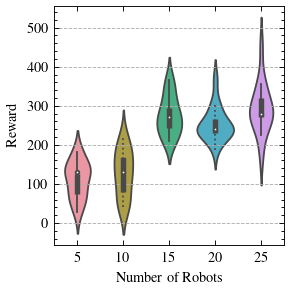

In [10]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'VALUE'
yl = 'Reward'
fs = hlwidth

# Process the data
# df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
fig,ax = plt.subplots(1,1,figsize=fs) 
# bp = df.boxplot(column='COEFS', by = XX, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, ax=ax)
bp = sns.violinplot(df[XX], df[YY])
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/performance_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Value Collected Over Distance Traveled 

Dropdown(description='Experiment:', index=26, options=('/home/eksander/geth-argos/MarketForaging/results/data/…

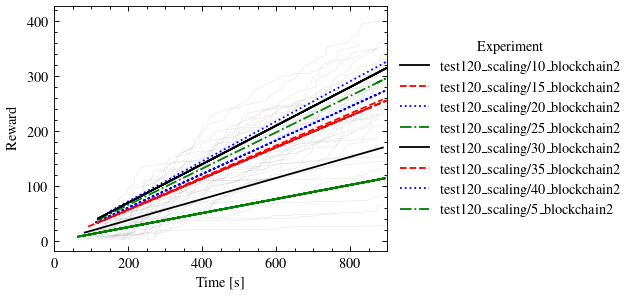

In [4]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')

# Axis data options
X_axis = 'TIME'

# Process the dataframe
df = df.groupby(['EXP']).apply(lambda x: LinearRegression0(x, X_axis, 'VALUE'))
# df = df[df['CONTROLLER'] == 'blockchain3']

# Create plot
ax = plt.axes()
df.set_index(X_axis).groupby(['EXP'])['LREG'].plot(ax=ax)
df.set_index(X_axis).groupby(['EXP','REP'])['VALUE'].plot(ax=ax, label='_nolegend_', color='gray', linestyle = '-', linewidth=0.2, alpha=0.3, zorder=0)

# Edit plot
ax.set_xlim(xmin=0,xmax = df[X_axis].max())
ax.set_ylabel('Reward')
if X_axis == 'DIST':
    ax.set_xlabel('Distance Traveled [m]')
else:
    ax.set_xlabel('Time [s]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Experiment')

## Efficiency (boxplot)

Dropdown(description='Experiment:', index=1, options=('100_epsilon_1', '110_epsilon', '130_staking', 'eco', 's…

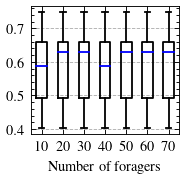

In [26]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'SCOUT_DIST'
XX = 'CONTROLLER'
BP = 'Robots'
yl = 'Scouting efficiency'
fs = 0.66*hlwidth
# df = df.query('Recruits in [0,1]')
# df = df.query('Robots==25')

# Process the data
df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharex=True, figsize=fs)

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
# for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('')   

# bp[0].set_title('No Blockchain (Individualist)')
# bp[1].set_title('Blockchain (Individualist)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/efficiency_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()


## Total Value Collected (boxplot)

Dropdown(description='Experiment:', index=1, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '130_st…

,ID,TIME,DIST,RECRUIT_DIST,SCOUT_DIST,red,green,blue,yellow,TOTAL,VALUE,EXP,CFG,REP,CONTROLLER,Robots,forage_rate
53363,0,0.017,0.000000,0.000000,0.000000,0,0,0,0,0,0,110_epsilon,11_10,007,10,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
53364,0,0.113,0.000000,0.000000,0.000000,0,0,0,0,0,0,110_epsilon,11_10,007,10,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
53365,0,0.209,0.000000,0.000000,0.000000,0,0,0,0,0,0,110_epsilon,11_10,007,10,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
53366,0,0.317,0.000000,0.000000,0.000000,0,0,0,0,0,0,110_epsilon,11_10,007,10,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
53367,0,0.406,0.000315,0.000315,0.000315,0,0,0,0,0,0,110_epsilon,11_10,007,10,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764027,0,899.529,794.636665,794.636665,305.772260,23,2,5,7,37,140,110_epsilon,11_90,010,90,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
764028,0,899.649,794.700945,794.700945,305.824840,23,2,5,7,37,140,110_epsilon,11_90,010,90,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
764029,0,899.728,794.765363,794.765363,305.889258,23,2,5,7,37,140,110_epsilon,11_90,010,90,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"
764030,0,899.829,794.829919,794.829919,305.941176,23,2,5,7,37,140,110_epsilon,11_90,010,90,11,"{'red': 7, 'green': 7, 'blue': 7, 'yellow': 7}"


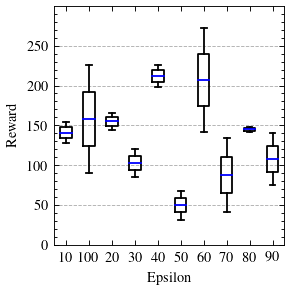

In [35]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'forage_rate', alias = 'forage_rate')


# Plot options
XX = 'CONTROLLER'
YY = 'VALUE'
BP = 'Robots'
yl = 'Reward'
fs = hlwidth

df = df[df['forage_rate'] == '{\'red\': 7, \'green\': 7, \'blue\': 7, \'yellow\': 7}']

display(df)
# df = df.query('Recruits==0 or Recruits==1')

# Process the data  
df = df.groupby(['Robots', 'CONTROLLER', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Epsilon")
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
# bp[0].set_title('Individualist (no blockchain)')
# bp[1].set_title('Individualist (blockchain)')
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

SelectMultiple(description='Experiment:', index=(23, 24, 25), options=('/home/eksander/geth-argos/MarketForagi…

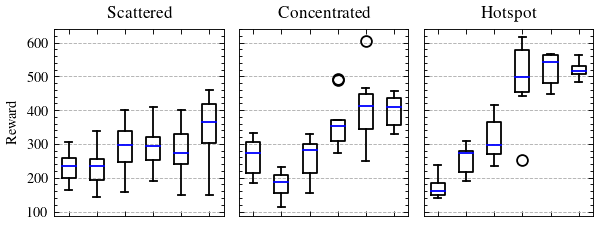

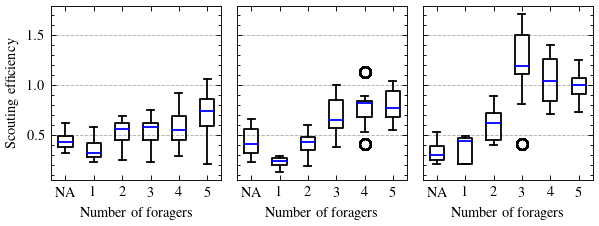

In [10]:
display(EXP_multiple)
EXP = EXP_multiple.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df2(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
YY = 'VALUE'
XX = 'Recruits'
BP = 'EXP'
yl = 'Reward'
titles = ['Scattered', 'Concentrated', 'Hotspot']
fs = fl22

# Process the data
df = df.groupby(['EXP', 'CFG','Recruits', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharey=True, figsize=fs, layout=[1,3])

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("")
for axi in bp: 
    labels = axi.get_xticklabels()
    labels[0] = 'NA'
    axi.set_xticklabels("")
    
bp[0].set_ylabel(yl)
i=0
for axi in bp: 
    axi.set_title(titles[i]) 
    i = i+1
plt.gcf().tight_layout()

plt.savefig("plots/multi/value.png", bbox_inches='tight', dpi=600)
plt.show()
#######################################################################################################

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = get_param_df2(df, 'generic_params', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0
# df = df[pd.to_numeric(df['REP']) >= 10]
# Plot options
YY = 'SCOUT_DIST'
XX = 'Recruits'
BP = 'EXP'
yl = 'Scouting efficiency'
fs = fl22

# Process the data
df = df.groupby(['EXP', 'CFG', 'REP']).apply(lambda x: LinearRegression0(x, YY, 'VALUE'))

# Create plot
bp = df.groupby(BP).boxplot(column='COEFS', by = XX, sharey=True, figsize=fs, layout=[1,3])

# Edit plot 
plt.suptitle('')
for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(False)
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel("Number of foragers")
for axi in bp: 
    labels = axi.get_xticklabels()
    labels[0] = 'NA'
    axi.set_xticklabels(labels)
for axi in bp: axi.set_title('')  
    
bp[0].set_ylabel(yl)
plt.gcf().tight_layout()

plt.savefig("plots/multi/eff.png", bbox_inches='tight', dpi=600)
plt.show()


## Distance Travelled Ratio (boxplot)

Dropdown(description='Experiment:', index=1, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '130_st…

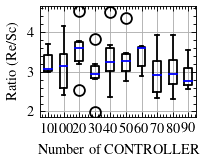

In [9]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'loop_function')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'generic', 'max_recruits', alias = 'Recruits')
df.loc[df['CONTROLLER'] == 'greedy', 'Recruits'] = 0

# Plot options
XX = 'CONTROLLER'
BP = 'Robots'
fs = hlwidth
# df = df.query('Robots==20')

# Process the dataframe  
df['%DIST_RECRUIT'] = df['RECRUIT_DIST']/df['SCOUT_DIST']
df = df.groupby(['Robots','CONTROLLER', 'REP'], as_index=False).agg({'%DIST_RECRUIT':'mean'})

# Create plot
bp = df.groupby(BP).boxplot(column=['%DIST_RECRUIT'], by=XX, sharey=True, layout=(2,2))

# Edit plot 
plt.suptitle('')
for ax in bp: ax.set_xlabel("Number of %s" % XX)
for ax in bp: ax.set_ylabel("Ratio (Re/Sc)")
for ax in bp: ax.set_title('') 
# plt.gcf().tight_layout()

plt.savefig("plots/experiment_"+EXP+"/ratio_bp_%s.png" % XX, bbox_inches='tight', dpi=600)
plt.show()

## Ticks per second (histogram)

Dropdown(description='Experiment:', index=1, options=('100_epsilon_1', '110_epsilon', '110_epsilon_2', '130_st…

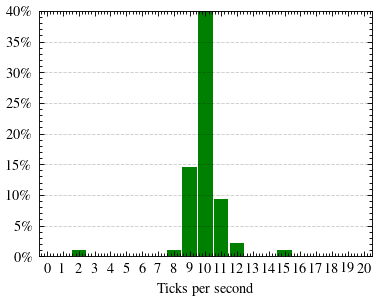

In [5]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'simulation')

# Process the dataframe 
df = df.get_param(df,'generic','tps')
bins = np.arange(df['tps'].min()-10, df['tps'].min()+12, 1)-0.5
xticks = np.arange(df['tps'].min()-10, df['tps'].min()+11, 1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPS'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])*0.9, color='green')

# Edit plot
ax.grid(axis='y', linestyle='--', color='k', alpha=0.2, zorder=0) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 0.4)
ax.set_xticks(xticks)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Ticks per second')

# Save plot
plt.savefig("plots/experiment_"+EXP+"/ticks_per_second.png", bbox_inches='tight')
plt.show()

## Robot Balances

Dropdown(description='Experiment:', options=('130_staking', 'eco', 'stake'), value='130_staking')

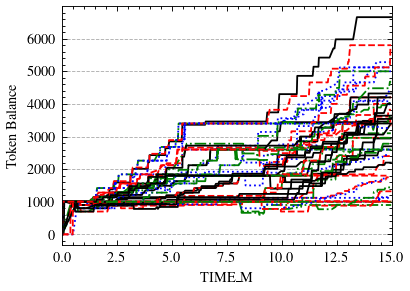

In [15]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'sc')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df['TIME_M'] = df['TIME']/60

# REP = ['003']
# df = df.query("REP in @REP")

# Plot options
XX = 'TIME_M'
YY = 'BALANCE'
yl = 'Token Balance'
fs = hlwidth

# Process the data

# Create plot
ax = plt.axes()
# fig,ax = plt.subplots(1,1,figsize=fs) 

df.set_index([XX]).groupby(['ID','EXP','REP'])[YY].plot(ax=ax)


# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlim(xmin=0, xmax=15)
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Working Income VS Staking Income

Dropdown(description='Experiment:', options=('130_staking', 'eco', 'stake'), value='130_staking')

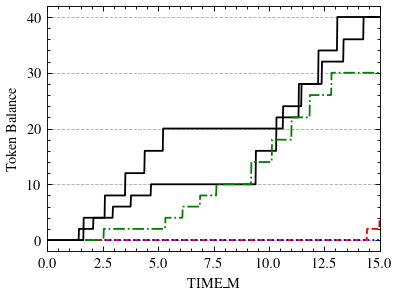

In [12]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'collection')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')


# REP = ['002']
# df = df.query("REP in @REP")

# Plot options
XX = 'TIME_M'
YY = [str(x) for x in range(1,int(df['Robots'].unique())+1)]
yl = 'Token Balance'
fs = hlwidth

# Process the data
df['SUM'] = df[YY].sum(axis=1)
df['TIME_M'] = df['TIME']/60

# Create plot
ax = plt.axes()
# fig,ax = plt.subplots(1,1,figsize=fs) 
# df.set_index([XX]).groupby(['ID','EXP','REP'])[YY].plot(ax=ax)
df.set_index([XX]).groupby(['REP'])['1'].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlim(xmin=0, xmax=15)
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
# plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Blockchain Visualizer

In [ ]:
# Select which experiment to plot the whole blockchain
tic()
# Select what data to read
EXP = 'test115/20_blockchain2'
REP = ['002']
ID = range(1,100)

# Collect data
df = create_df(EXP, 'block')
df = df.query("REP in @REP")

# Remove duplicate blocks
df = df.drop_duplicates('HASH').sort_values('BLOCK')
genesis = df['PHASH'].iloc[0]
# display(df)
bc = create_digraph(df)
toc()
# mainchain_path is the longest path extracted with nx
bc_nx = convert_digraph(bc)
mainchain_path = get_mainchain(bc_nx, source=genesis, target=str(df['HASH'].iloc[-1]))

# Block hashes which are in mainchain_path -> mainchain 
df_mainchain = df.query("HASH in @mainchain_path")
# mainchain = create_digraph(df_mainchain)
# mainchain_nx = convert_digraph(mainchain)

# Block hashes not in the mainchain_path -> forks
df_forks = df.query("HASH not in @mainchain_path")
forks = create_digraph(df_forks)
forks_nx = convert_digraph(forks)

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')
toc()

# bc

In [ ]:
MIN_FORK_LENGTH = 0

fork_paths = [[y] for y in df_leafs['HASH']]
df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)

fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)

nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)

df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @mainchain_path')
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')

# Do something cool? Idk, for example try to keep all forks at same level (slow!)
df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
bc_trimmed.render('plots/blockchain', format='pdf', view=True)
# bc_trimmed